In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

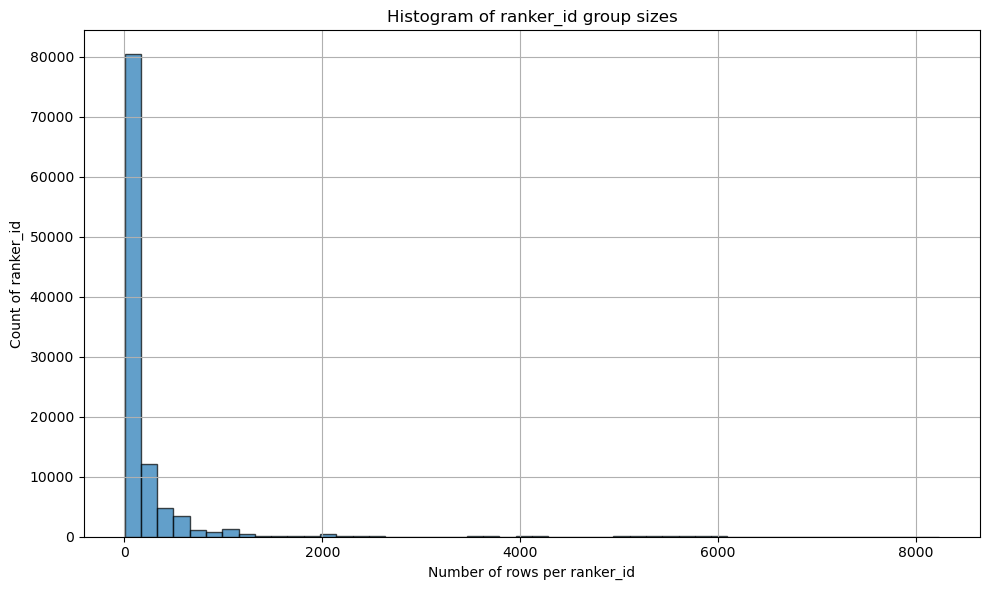

In [2]:
import polars as pl
import matplotlib.pyplot as plt

# Load data
train = pl.read_parquet('data/train_filled.parquet')

# 計算每個 ranker_id 出現次數
ranker_counts = (
    train
    .group_by("ranker_id")
    .agg(pl.len().alias("n_rows"))
    .sort("n_rows")
)

# 轉成 pandas
ranker_counts_pd = ranker_counts.to_pandas()

# 畫 histogram
plt.figure(figsize=(10,6))
plt.hist(ranker_counts_pd["n_rows"], bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Number of rows per ranker_id")
plt.ylabel("Count of ranker_id")
plt.title("Histogram of ranker_id group sizes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
ranker_counts_filtered = ranker_counts.filter(pl.col("n_rows") >= 3)
summary_filtered = ranker_counts_filtered.select([
    pl.col("n_rows").min().alias("min"),
    pl.col("n_rows").max().alias("max"),
    pl.col("n_rows").mean().alias("mean"),
    pl.col("n_rows").median().alias("median"),
    pl.col("n_rows").quantile(0.25, "nearest").alias("25%"),
    pl.col("n_rows").quantile(0.75, "nearest").alias("75%"),
    pl.col("n_rows").std().alias("std"),
])

print(summary_filtered)


shape: (1, 7)
┌─────┬──────┬────────────┬────────┬──────┬───────┬────────────┐
│ min ┆ max  ┆ mean       ┆ median ┆ 25%  ┆ 75%   ┆ std        │
│ --- ┆ ---  ┆ ---        ┆ ---    ┆ ---  ┆ ---   ┆ ---        │
│ u32 ┆ u32  ┆ f64        ┆ f64    ┆ f64  ┆ f64   ┆ f64        │
╞═════╪══════╪════════════╪════════╪══════╪═══════╪════════════╡
│ 3   ┆ 8236 ┆ 177.851194 ┆ 53.0   ┆ 21.0 ┆ 162.0 ┆ 452.477068 │
└─────┴──────┴────────────┴────────┴──────┴───────┴────────────┘


In [1]:
import numpy as np
import polars as pl

# 讀取
train_filled = pl.read_parquet("data/train_filled.parquet")

# 排除欄
exclude_cols = [
    'Id', 'ranker_id', 'selected', 'profileId', 'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage',
    'pricingInfo_passengerCount'
]
feature_cols = [c for c in train_filled.columns if c not in exclude_cols]

# 轉 float32
float64_cols = [c for c in feature_cols if train_filled[c].dtype == pl.Float64]
train_filled = train_filled.with_columns(
    [pl.col(c).cast(pl.Float32) for c in float64_cols]
)



In [2]:
from scripts.group_wise import split_data_by_group_size

result = split_data_by_group_size(
    train_filled,
    bins=[3, 21, 162, 1000, None],
    labels=["small", "medium", "large", "xlarge"]
)


import gc

del train_filled
gc.collect()


✅ small: 266398 rows, approx 185.30 MB
✅ medium: 3277599 rows, approx 2300.61 MB
✅ large: 8231834 rows, approx 5808.74 MB
✅ xlarge: 6363568 rows, approx 4540.96 MB
✅ 分群統計：
shape: (5, 4)
┌────────────────┬──────────┬────────────┬────────────────────┐
│ group_category ┆ n_groups ┆ total_rows ┆ avg_rows_per_group │
│ ---            ┆ ---      ┆ ---        ┆ ---                │
│ str            ┆ u32      ┆ u32        ┆ f64                │
╞════════════════╪══════════╪════════════╪════════════════════╡
│ large          ┆ 22430    ┆ 8231834    ┆ 367.00107          │
│ medium         ┆ 51565    ┆ 3277599    ┆ 63.562475          │
│ small          ┆ 24837    ┆ 266398     ┆ 10.725853          │
│ unknown        ┆ 3547     ┆ 5973       ┆ 1.683958           │
│ xlarge         ┆ 3160     ┆ 6363568    ┆ 2013.787342        │
└────────────────┴──────────┴────────────┴────────────────────┘


0

In [3]:
del float64_cols
gc.collect()


31

In [3]:
import os
import gc
import xgboost as xgb
import numpy as np
import polars as pl
from scripts.group_wise import prepare_train_val_split
from scripts.hitrate import compute_hitrate_at_3

# 自訂模型儲存目錄
model_dir = "model_output/all_features_xgb/"
os.makedirs(model_dir, exist_ok=True)
print(f"✅ Model folder: {model_dir}")

# 預設 XGB 參數
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}

split_labels = ["small", "medium", "large", "xlarge"]

split_data = result["split_data"]

# 建立 train_dataset 子資料夾
train_dataset_dir = os.path.join(model_dir, "train_dataset")
os.makedirs(train_dataset_dir, exist_ok=True)

# 存 parquet 到 train_dataset 資料夾
for label, df in split_data.items():
    path = os.path.join(train_dataset_dir, f"{label}.parquet")
    print(f"💾 儲存 {label} 到 {path}")
    df.write_parquet(path)


# 清理記憶體
split_data.clear()
del result
gc.collect()

print("✅ split_data 已清空，記憶體應已釋放")

all_groups_val_np = []
all_y_val_np = []
all_val_preds = []
hitrate_per_group = {}

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    data = pl.read_parquet(os.path.join(train_dataset_dir, f"{label}.parquet"))

    split_result = prepare_train_val_split(
        result={"split_data": {label: data}},
        split_label=label,
        feature_cols=feature_cols,
        train_fraction=0.8
    )

    dtrain = xgb.DMatrix(
        split_result["X_train_np"],
        label=split_result["y_train_np"]
    )
    dtrain.set_group(split_result["group_sizes_train"])

    dval = xgb.DMatrix(
        split_result["X_val_np"],
        label=split_result["y_val_np"]
    )
    dval.set_group(split_result["group_sizes_val"])

    xgb_model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=20
    )

    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model.save_model(model_path)
    print(f"✅ 已儲存模型: {model_path}")

    val_preds = xgb_model.predict(dval)

    hitrate = compute_hitrate_at_3(
        split_result["groups_val_np"],
        split_result["y_val_np"],
        val_preds
    )
    hitrate_per_group[label] = hitrate

    all_groups_val_np.append(split_result["groups_val_np"])
    all_y_val_np.append(split_result["y_val_np"])
    all_val_preds.append(val_preds)

    del dtrain, dval, xgb_model, val_preds, split_result, data
    gc.collect()
    print("🧹 記憶體已清理")

print("\n⚡ 合併所有驗證結果計算 HitRate ⚡")
all_groups_val_np = np.concatenate(all_groups_val_np)
all_y_val_np = np.concatenate(all_y_val_np)
all_val_preds = np.concatenate(all_val_preds)

overall_hitrate = compute_hitrate_at_3(
    all_groups_val_np,
    all_y_val_np,
    all_val_preds
)

print("\n💡 每組 Hitrate：")
for label, h in hitrate_per_group.items():
    print(f"{label}: {h:.4f}")

print(f"\n🎯 全部合併 HitRate: {overall_hitrate:.4f}")

# 將 hitrate 寫入 CSV
hitrate_records = [
    {"split_label": label, "hitrate": h}
    for label, h in hitrate_per_group.items()
]
hitrate_records.append({"split_label": "overall", "hitrate": overall_hitrate})

hitrate_df = pl.DataFrame(hitrate_records)
csv_path = os.path.join(model_dir, "hitrate_summary.csv")
hitrate_df.write_csv(csv_path)
print(f"\n✅ 已儲存所有 Hitrate 結果至 {csv_path}")


✅ Model folder: model_output/all_features_xgb/
💾 儲存 small 到 model_output/all_features_xgb/small.parquet
💾 儲存 medium 到 model_output/all_features_xgb/medium.parquet
💾 儲存 large 到 model_output/all_features_xgb/large.parquet
💾 儲存 xlarge 到 model_output/all_features_xgb/xlarge.parquet
✅ split_data 已清空，記憶體應已釋放

🚀 處理分群: small
✅ Train: 212763 rows, 19869 groups
✅ Val: 53635 rows, 4968 groups
[0]	train-ndcg@3:0.71858	val-ndcg@3:0.70095
[20]	train-ndcg@3:0.82284	val-ndcg@3:0.76082
[40]	train-ndcg@3:0.84241	val-ndcg@3:0.76522
[60]	train-ndcg@3:0.85282	val-ndcg@3:0.76886
[80]	train-ndcg@3:0.86332	val-ndcg@3:0.77270
[100]	train-ndcg@3:0.87150	val-ndcg@3:0.77785
[120]	train-ndcg@3:0.87938	val-ndcg@3:0.77988
[140]	train-ndcg@3:0.88723	val-ndcg@3:0.78332
[160]	train-ndcg@3:0.89567	val-ndcg@3:0.78402
[180]	train-ndcg@3:0.90271	val-ndcg@3:0.78680
[200]	train-ndcg@3:0.90982	val-ndcg@3:0.78898
[220]	train-ndcg@3:0.91557	val-ndcg@3:0.79024
[240]	train-ndcg@3:0.92090	val-ndcg@3:0.79211
[260]	train-ndcg@3:0.92

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_27522/4048498045.py:84: UserWarning: [05:02:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.8009
🧹 記憶體已清理

🚀 處理分群: medium
✅ Train: 2620635 rows, 41252 groups
✅ Val: 656964 rows, 10313 groups
[0]	train-ndcg@3:0.51234	val-ndcg@3:0.50875
[20]	train-ndcg@3:0.61800	val-ndcg@3:0.57626
[40]	train-ndcg@3:0.63789	val-ndcg@3:0.58605
[60]	train-ndcg@3:0.64847	val-ndcg@3:0.59310
[80]	train-ndcg@3:0.66145	val-ndcg@3:0.60056
[100]	train-ndcg@3:0.67083	val-ndcg@3:0.60328
[120]	train-ndcg@3:0.67821	val-ndcg@3:0.60656
[140]	train-ndcg@3:0.68731	val-ndcg@3:0.61047
[160]	train-ndcg@3:0.69713	val-ndcg@3:0.61486
[180]	train-ndcg@3:0.70599	val-ndcg@3:0.61786
[200]	train-ndcg@3:0.71592	val-ndcg@3:0.62097
[220]	train-ndcg@3:0.72425	val-ndcg@3:0.62271
[240]	train-ndcg@3:0.73179	val-ndcg@3:0.62718
[260]	train-ndcg@3:0.74013	val-ndcg@3:0.62925
[280]	train-ndcg@3:0.74690	val-ndcg@3:0.63101
[300]	train-ndcg@3:0.75391	val-ndcg@3:0.63267
[320]	train-ndcg@3:0.76045	val-ndcg@3:0.63426
[340]	train-ndcg@3:0.76689	val-ndcg@3:0.63708
[360]	train-ndcg@3:0.77285	val-ndcg@3

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_27522/4048498045.py:84: UserWarning: [05:06:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.6115
🧹 記憶體已清理

🚀 處理分群: large
✅ Train: 6582124 rows, 17944 groups
✅ Val: 1649710 rows, 4486 groups
[0]	train-ndcg@3:0.34411	val-ndcg@3:0.34360
[20]	train-ndcg@3:0.43250	val-ndcg@3:0.40141
[40]	train-ndcg@3:0.45590	val-ndcg@3:0.40933
[60]	train-ndcg@3:0.47291	val-ndcg@3:0.41867
[80]	train-ndcg@3:0.48401	val-ndcg@3:0.42464
[100]	train-ndcg@3:0.49537	val-ndcg@3:0.42931
[120]	train-ndcg@3:0.50821	val-ndcg@3:0.43319
[140]	train-ndcg@3:0.52184	val-ndcg@3:0.43853
[160]	train-ndcg@3:0.53852	val-ndcg@3:0.44298
[180]	train-ndcg@3:0.55563	val-ndcg@3:0.44815
[200]	train-ndcg@3:0.57319	val-ndcg@3:0.45228
[220]	train-ndcg@3:0.58869	val-ndcg@3:0.45409
[240]	train-ndcg@3:0.60623	val-ndcg@3:0.45980
[260]	train-ndcg@3:0.61957	val-ndcg@3:0.46298
[280]	train-ndcg@3:0.63025	val-ndcg@3:0.46591
[300]	train-ndcg@3:0.64037	val-ndcg@3:0.46780
[320]	train-ndcg@3:0.65110	val-ndcg@3:0.46830
[340]	train-ndcg@3:0.66106	val-ndcg@3:0.47147
[360]	train-ndcg@3:0.67272	val-ndcg@3:

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_27522/4048498045.py:84: UserWarning: [05:43:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.3259
🧹 記憶體已清理

🚀 處理分群: xlarge
✅ Train: 5094812 rows, 2528 groups
✅ Val: 1268756 rows, 632 groups
[0]	train-ndcg@3:0.38909	val-ndcg@3:0.39619
[20]	train-ndcg@3:0.51967	val-ndcg@3:0.45160
[40]	train-ndcg@3:0.55259	val-ndcg@3:0.44470
[60]	train-ndcg@3:0.58671	val-ndcg@3:0.45014
[80]	train-ndcg@3:0.62100	val-ndcg@3:0.45627
[100]	train-ndcg@3:0.66453	val-ndcg@3:0.45785
[120]	train-ndcg@3:0.69791	val-ndcg@3:0.46632
[140]	train-ndcg@3:0.72316	val-ndcg@3:0.46525
[160]	train-ndcg@3:0.75705	val-ndcg@3:0.47314
[180]	train-ndcg@3:0.77923	val-ndcg@3:0.47420
[200]	train-ndcg@3:0.79515	val-ndcg@3:0.47931
[220]	train-ndcg@3:0.81058	val-ndcg@3:0.47911
[240]	train-ndcg@3:0.82385	val-ndcg@3:0.48612
[260]	train-ndcg@3:0.83431	val-ndcg@3:0.48807
[280]	train-ndcg@3:0.84669	val-ndcg@3:0.49140
[300]	train-ndcg@3:0.85284	val-ndcg@3:0.49225
[320]	train-ndcg@3:0.86019	val-ndcg@3:0.49319
[340]	train-ndcg@3:0.86876	val-ndcg@3:0.49532
[360]	train-ndcg@3:0.87657	val-ndcg@3:0

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_27522/4048498045.py:84: UserWarning: [06:02:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2294
🧹 記憶體已清理

⚡ 合併所有驗證結果計算 HitRate ⚡
✅ HitRate@3 (groups size in [10, inf]): 0.5565

💡 每組 Hitrate：
small: 0.8009
medium: 0.6115
large: 0.3259
xlarge: 0.2294

🎯 全部合併 HitRate: 0.5565

✅ 已儲存所有 Hitrate 結果至 model_output/all_features_xgb/hitrate_summary.csv


# model 

In [11]:
len(feature_cols)

152

In [19]:
import os
import xgboost as xgb
import pandas as pd

# 指定你的模型資料夾
model_dir = "model_output/all_features_xgb"

# 選定要讀的 label
label = "xlarge"

# 讀取模型
model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
booster = xgb.Booster()
booster.load_model(model_path)
print(f"✅ 已讀取模型 {model_path}")

# 特徵名稱（要跟你訓練的feature_cols一致）
feature_names = feature_cols  # List of 165 columns

# 取重要性
importance_types = ["weight", "gain", "cover"]
importance_all = {}

for imp_type in importance_types:
    imp_raw = booster.get_score(importance_type=imp_type)
    imp_named = {}
    for k, v in imp_raw.items():
        idx = int(k[1:])
        real_name = feature_names[idx]
        imp_named[real_name] = v
    sorted_imp = sorted(imp_named.items(), key=lambda x: x[1], reverse=True)
    importance_all[imp_type] = sorted_imp

# 個別DataFrame
df_weight = pd.DataFrame(importance_all["weight"], columns=["feature", "weight"])
df_weight["weight_rank_pos"] = df_weight.index

df_gain = pd.DataFrame(importance_all["gain"], columns=["feature", "gain"])
df_gain["gain_rank_pos"] = df_gain.index

df_cover = pd.DataFrame(importance_all["cover"], columns=["feature", "cover"])
df_cover["cover_rank_pos"] = df_cover.index

# 先建一個完整feature表
df_all = pd.DataFrame({"feature": feature_names})

# 合併 (用左連接保留所有特徵)
df_merged = (
    df_all
    .merge(df_weight, on="feature", how="left")
    .merge(df_gain, on="feature", how="left")
    .merge(df_cover, on="feature", how="left")
)

# 補rank_pos (沒用到的設為9999)
df_merged["weight_rank_pos"] = df_merged["weight_rank_pos"].fillna(9999)
df_merged["gain_rank_pos"] = df_merged["gain_rank_pos"].fillna(9999)
df_merged["cover_rank_pos"] = df_merged["cover_rank_pos"].fillna(9999)

# 計算最小排名
df_merged["min_rank"] = df_merged[["weight_rank_pos", "gain_rank_pos", "cover_rank_pos"]].min(axis=1)

# 排序
df_merged_sorted = df_merged.sort_values("min_rank")

# 顯示前50
print(df_merged_sorted.head(50))


# 建立 model_importance 子資料夾
model_importance_dir = os.path.join(model_dir, "model_importance")
os.makedirs(model_importance_dir, exist_ok=True)

# 如果要儲存
csv_path = os.path.join(model_importance_dir, f"feature_importance_{label}_all_features.csv")
df_merged_sorted.to_csv(csv_path, index=False)
print(f"✅ 已輸出所有特徵重要性到 {csv_path}")


✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_xlarge.bin
                                               feature  weight  \
113                                         totalPrice  8556.0   
13                          legs0_segments0_cabinClass    94.0   
61   legs1_segments0_baggageAllowance_weightMeasure...     3.0   
1                                            companyID  6120.0   
62                          legs1_segments0_cabinClass    75.0   
16                        legs0_segments0_flightNumber  5914.0   
71              legs1_segments1_arrivalTo_airport_iata     7.0   
23           legs0_segments1_baggageAllowance_quantity     9.0   
21         legs0_segments1_arrivalTo_airport_city_iata    99.0   
131                              days_before_departure  5607.0   
147                                 legs0_main_carrier    20.0   
65                        legs1_segments0_flightNumber  5268.0   
70         legs1_segments1_arrivalTo_airport_city_iata     1.0   
136             

# Predcit

In [ ]:
from scripts.group_wise import split_data_by_group_size
import numpy as np
import polars as pl

# 讀取
test_filled = pl.read_parquet("data/test_filled.parquet")

# 排除欄
exclude_cols = [
    'Id', 'ranker_id', 'selected', 'profileId', 'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage',
    'pricingInfo_passengerCount'
]
feature_cols = [c for c in test_filled.columns if c not in exclude_cols]


result = split_data_by_group_size(
    test_filled,
    bins=[0, 21, 162, 1000, None],
    labels=["small", "medium", "large", "xlarge"]
)

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_24830/1368847609.py:24: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df = df.with_row_count("global_row_nr")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_24830/1368847609.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n_rows"))


✅ small: 149062 rows, approx 125.85 MB
✅ medium: 1309838 rows, approx 1116.81 MB
✅ large: 2278777 rows, approx 1952.75 MB
✅ xlarge: 3160099 rows, approx 2725.20 MB
✅ 分群統計：
shape: (4, 4)
┌────────────────┬──────────┬────────────┬────────────────────┐
│ group_category ┆ n_groups ┆ total_rows ┆ avg_rows_per_group │
│ ---            ┆ ---      ┆ ---        ┆ ---                │
│ str            ┆ u32      ┆ u32        ┆ f64                │
╞════════════════╪══════════╪════════════╪════════════════════╡
│ large          ┆ 7314     ┆ 2278777    ┆ 311.563713         │
│ medium         ┆ 21251    ┆ 1309838    ┆ 61.636535          │
│ small          ┆ 15536    ┆ 149062     ┆ 9.594619           │
│ xlarge         ┆ 1130     ┆ 3160099    ┆ 2796.547788        │
└────────────────┴──────────┴────────────┴────────────────────┘


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_24830/1368847609.py:66: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_groups"),


In [ ]:
def prepare_prediction(
    result: dict,
    split_label: str,
    feature_cols: list,
):
    """
    直接準備所有資料用於預測，不分train/val。
    """
    df = result["split_data"][split_label]

    # 全部 rows
    X_np = df.select(feature_cols).to_numpy()
    y_np = df.select("selected").to_numpy().flatten()
    groups_np = df.select("ranker_id").to_numpy().flatten()
    rows_np = df.select("global_row_nr").to_numpy().flatten()

    group_sizes = (
        pl.DataFrame({"ranker_id": groups_np})
        .group_by("ranker_id")
        .agg(pl.len().alias("size"))
        .sort("ranker_id")["size"]
        .to_numpy()
    )
    print(f"✅ {split_label} 分組大小: {group_sizes}")
    return {
        "X_np": X_np,
        "y_np": y_np,
        "groups_np": groups_np,
        "global_row_np": rows_np,
        "group_sizes": group_sizes,
    }

In [ ]:
import xgboost as xgb
import numpy as np
import gc
from scripts.group_wise import prepare_prediction


# 三個分組
split_labels = ["small", "medium", "large", "xlarge"]

all_groups_val_np = []
all_X_val_np = []
all_val_preds = []
all_rows_val_np = []

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    split_result = prepare_prediction(
        result=result,
        split_label=label,
        feature_cols=feature_cols,
    )

    dval = xgb.DMatrix(split_result["X_np"])
    dval.set_group(split_result["group_sizes"])

    xgb_model = xgb.Booster(model_file=f"xgb_ranker_{label}.bin")
    val_preds = xgb_model.predict(dval)

    all_groups_val_np.append(split_result["groups_np"])
    all_X_val_np.append(split_result["X_np"])
    all_val_preds.append(val_preds)
    all_rows_val_np.append(split_result["global_row_np"])

all_groups_val_np = np.concatenate(all_groups_val_np)
all_X_val_np = np.concatenate(all_X_val_np)
all_val_preds = np.concatenate(all_val_preds)
all_rows_val_np = np.concatenate(all_rows_val_np)

preds_df = pl.DataFrame({
    "global_row_nr": all_rows_val_np,
    "prediction": all_val_preds
})
test_filled_with_preds = (
    test_filled
    .with_row_count("global_row_nr")
    .join(preds_df, on="global_row_nr", how="left")
)
test_filled_with_preds = test_filled_with_preds.drop("global_row_nr")

restored_clean = (
    test_filled_with_preds
    .drop("prediction")
)

equal = test_filled.equals(restored_clean)
print("✅ 是否與原始 test_filled 完全一致：", equal)



🚀 處理分群: small
✅ small 分組大小: [ 3  6 13 ...  1  6 12]

🚀 處理分群: medium
✅ medium 分組大小: [ 21 105  33 ... 129  28  71]

🚀 處理分群: large
✅ large 分組大小: [242 262 260 ... 209 285 355]

🚀 處理分群: xlarge
✅ xlarge 分組大小: [4677 5509 1274 ... 1059 5555 1864]


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_24830/2314796702.py:46: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("global_row_nr")


✅ 是否與原始 test_filled 完全一致： True


In [4]:
test_filled_with_preds = test_filled_with_preds.drop("global_row_nr")
test_filled_with_preds

Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs0_departureAt_business_time,legs0_departureAt_day_period,legs0_arrivalAt_hour,legs0_arrivalAt_weekday,legs0_arrivalAt_business_time,legs0_arrivalAt_day_period,legs1_departureAt_hour,legs1_departureAt_weekday,legs1_departureAt_business_time,legs1_departureAt_day_period,legs1_arrivalAt_hour,legs1_arrivalAt_weekday,legs1_arrivalAt_business_time,legs1_arrivalAt_day_period,is_round_trip,days_before_departure,legs0_num_transfers,legs1_num_transfers,legs0_is_direct,legs1_is_direct,both_legs_direct,legs0_main_carrier,legs1_main_carrier,legs0_all_segments_carrier_same,legs1_all_segments_carrier_same,both_legs_carrier_all_same,has_frequentFlyer,n_ff_programs,legs0_segments0_aircraft_code_is_missing,legs0_segments1_aircraft_code_is_missing,legs0_segments2_aircraft_code_is_missing,legs0_segments3_aircraft_code_is_missing,legs1_segments0_aircraft_code_is_missing,legs1_segments1_aircraft_code_is_missing,legs1_segments2_aircraft_code_is_missing,legs1_segments3_aircraft_code_is_missing,prediction
i64,i8,i64,i64,i32,i64,i8,i8,str,str,i64,i32,i32,i32,f64,f64,f64,i32,i64,i32,i32,i32,f64,i32,i32,i32,f64,f64,f64,i32,i64,i32,i32,i32,f64,i32,i32,…,i32,i32,i8,i8,i32,i32,i8,i8,i32,i32,i8,i8,i32,i32,i8,i32,i8,i8,i8,i8,i8,i32,i32,i8,i8,i8,i8,i32,i8,i8,i8,i8,i8,i8,i8,i8,f32
18144679,1,62840,0,371,36,0,0,"""2024-12-19T11:20:00""","""2024-12-19T06:50:00""",150,12,399,424,0.0,0.0,1.0,303,150,441,127,167,4.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,1,11,4,0,1,21,6,0,3,21,6,0,3,1,50,0,0,1,1,1,127,114,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.690551
18144680,1,62840,0,371,36,0,0,"""2024-12-19T11:20:00""","""2024-12-19T06:50:00""",150,12,399,424,1.0,0.0,1.0,303,150,441,127,167,4.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,1,11,4,0,1,21,6,0,3,21,6,0,3,1,50,0,0,1,1,1,127,114,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.352745
18144681,1,62840,0,371,36,0,0,"""2024-12-19T11:20:00""","""2024-12-19T06:50:00""",150,12,399,424,2.0,0.0,1.0,303,150,441,127,167,4.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,1,11,4,0,1,21,6,0,3,21,6,0,3,1,50,0,0,1,1,1,127,114,1,1,0,0,0,0,0,0,0,0,0,0,0,-2.729578
18144682,1,62840,0,371,36,0,0,"""2024-12-19T12:45:00""","""2024-12-19T08:25:00""",140,9,399,424,0.0,0.0,1.0,78,140,1743,137,179,7.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,1,12,4,0,2,12,6,0,2,12,6,0,2,1,50,0,0,1,1,1,137,121,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.996519
18144683,1,62840,0,371,36,0,0,"""2024-12-19T12:45:00""","""2024-12-19T08:25:00""",140,9,399,424,1.0,0.0,1.0,78,140,1743,137,179,7.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,1,12,4,0,2,12,6,0,2,12,6,0,2,1,50,0,0,1,1,1,137,121,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.557726
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
25043143,0,57320,65,371,36,1,0,"""2025-01-08T12:50:00""","""2025-01-08T09:05:00""",165,12,15,16,

In [14]:
test_filled_with_preds = test_filled_with_preds.with_columns(
    pl.col("prediction")
      .rank(method="ordinal", descending=True)
      .over("ranker_id")
      .alias("selected")
)
test_filled_with_preds

Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs0_departureAt_day_period,legs0_arrivalAt_hour,legs0_arrivalAt_weekday,legs0_arrivalAt_business_time,legs0_arrivalAt_day_period,legs1_departureAt_hour,legs1_departureAt_weekday,legs1_departureAt_business_time,legs1_departureAt_day_period,legs1_arrivalAt_hour,legs1_arrivalAt_weekday,legs1_arrivalAt_business_time,legs1_arrivalAt_day_period,is_round_trip,days_before_departure,legs0_num_transfers,legs1_num_transfers,legs0_is_direct,legs1_is_direct,both_legs_direct,legs0_main_carrier,legs1_main_carrier,legs0_all_segments_carrier_same,legs1_all_segments_carrier_same,both_legs_carrier_all_same,has_frequentFlyer,n_ff_programs,legs0_segments0_aircraft_code_is_missing,legs0_segments1_aircraft_code_is_missing,legs0_segments2_aircraft_code_is_missing,legs0_segments3_aircraft_code_is_missing,legs1_segments0_aircraft_code_is_missing,legs1_segments1_aircraft_code_is_missing,legs1_segments2_aircraft_code_is_missing,legs1_segments3_aircraft_code_is_missing,prediction,rank_in_group
i64,i8,i64,i64,i32,i64,i8,i8,str,str,i64,i32,i32,i32,f64,f64,f64,i32,i64,i32,i32,i32,f64,i32,i32,i32,f64,f64,f64,i32,i64,i32,i32,i32,f64,i32,i32,…,i32,i8,i8,i32,i32,i8,i8,i32,i32,i8,i8,i32,i32,i8,i32,i8,i8,i8,i8,i8,i32,i32,i8,i8,i8,i8,i32,i8,i8,i8,i8,i8,i8,i8,i8,f32,u32
18144679,1,62840,0,371,36,0,0,"""2024-12-19T11:20:00""","""2024-12-19T06:50:00""",150,12,399,424,0.0,0.0,1.0,303,150,441,127,167,4.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,11,4,0,1,21,6,0,3,21,6,0,3,1,50,0,0,1,1,1,127,114,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.690551,77
18144680,1,62840,0,371,36,0,0,"""2024-12-19T11:20:00""","""2024-12-19T06:50:00""",150,12,399,424,1.0,0.0,1.0,303,150,441,127,167,4.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,11,4,0,1,21,6,0,3,21,6,0,3,1,50,0,0,1,1,1,127,114,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.352745,35
18144681,1,62840,0,371,36,0,0,"""2024-12-19T11:20:00""","""2024-12-19T06:50:00""",150,12,399,424,2.0,0.0,1.0,303,150,441,127,167,4.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,11,4,0,1,21,6,0,3,21,6,0,3,1,50,0,0,1,1,1,127,114,1,1,0,0,0,0,0,0,0,0,0,0,0,-2.729578,264
18144682,1,62840,0,371,36,0,0,"""2024-12-19T12:45:00""","""2024-12-19T08:25:00""",140,9,399,424,0.0,0.0,1.0,78,140,1743,137,179,7.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,12,4,0,2,12,6,0,2,12,6,0,2,1,50,0,0,1,1,1,137,121,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.996519,100
18144683,1,62840,0,371,36,0,0,"""2024-12-19T12:45:00""","""2024-12-19T08:25:00""",140,9,399,424,1.0,0.0,1.0,78,140,1743,137,179,7.0,102,424,475,0.0,0.0,0.0,453,0,6576,149,200,0.0,81,242,…,1,12,4,0,2,12,6,0,2,12,6,0,2,1,50,0,0,1,1,1,137,121,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.557726,66
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
25043143,0,57320,65,371,36,1,0,"""2025-01-08T12:50:00""","""2025-01-08T09:05:00""",165,12,15,16,2.0,0.0,1.0

In [15]:
subset_df = (
    test_filled_with_preds
    .select([
        "Id", "ranker_id", "selected"
    ])
    .with_columns(
        pl.col("Id").alias("__index_level_0__")
    )
    .with_columns([
        pl.col("Id").cast(pl.Int64),
        pl.col("ranker_id").cast(pl.Utf8),
        pl.col("selected").cast(pl.Int64),
        pl.col("__index_level_0__").cast(pl.Int64)
    ])
)

print(subset_df)


shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬──────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---      ┆ ---               │
│ i64      ┆ str                             ┆ i64      ┆ i64               │
╞══════════╪═════════════════════════════════╪══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 77       ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 35       ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 264      ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 100      ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 66       ┆ 18144683          │
│ …        ┆ …                               ┆ …        ┆ …                 │
│ 25043143 ┆ c5622e0de0594bde95a4dd8c1fcff7… ┆ 9        ┆ 25043143          │
│ 25043144 ┆ c5622e0de0594bde95a4dd8c1fcff

In [16]:
subset_df.write_parquet("submission.parquet")


In [13]:
subset_df

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",77,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",35,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",264,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",100,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",66,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",6,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",12,25043145


In [6]:
import numpy as np
import polars as pl

# 讀取
submission = pl.read_parquet("data/sample_submission.parquet")
submission

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",178,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",363,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",277,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",183,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",55,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",2,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",1,25043145
